In [ ]:
!pip install causationentropy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Center-For-Complex-Systems-Science/causationentropy/blob/main/notebooks/knn_causal_discovery_example.ipynb)

# k-Nearest Neighbor Causal Discovery Example
This notebook demonstrates causal network discovery using the **k-Nearest Neighbor** information method with distance-based information.

## Overview
- Generate synthetic time series with known causal structure
- Visualize the dynamics and network structure
- Apply causal discovery using k-Nearest Neighbor conditional mutual information
- Evaluate performance using ROC-AUC metric\n\n

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Import causal discovery components
from causationentropy.core.discovery import discover_network
from causationentropy.datasets.synthetic import linear_stochastic_gaussian_process

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('tab10')

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Create Ground Truth Network\n\nWe'll create a directed graph that represents the true causal relationships.

In [2]:
# Create ground truth network

n_nodes = 5
seed = 42

np.random.seed(seed)

G_true = nx.DiGraph()
G_true.add_nodes_from(range(n_nodes))

# Add specific causal edges
edges = [(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]
G_true.add_edges_from(edges)

print(f'Ground truth network has {G_true.number_of_nodes()} nodes and {G_true.number_of_edges()} edges')
print(f'Edges: {list(G_true.edges())}')

A_true = nx.adjacency_matrix(G_true).toarray()
print(f'\\nGround truth adjacency matrix:')
print(A_true)

Ground truth network has 5 nodes and 5 edges
Edges: [(0, 1), (0, 2), (1, 3), (2, 4), (3, 4)]
\nGround truth adjacency matrix:
[[0 1 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]


## 2. Generate Synthetic k-Nearest Neighbor Data\n\nGenerate distance-based information with the known causal structure.

In [4]:
# Generate synthetic k-Nearest Neighbor data
T = 200  # Time series length
# Generate data using linear_stochastic_gaussian_process
data, A_generated = linear_stochastic_gaussian_process(
    n=n_nodes,
    T=T,
    G=G_true,
    rho=0.7, p=0.0,
    seed=seed)
print(f'Generated k-Nearest Neighbor data with shape: {data.shape}')
print(f'Data statistics:')
print(f'  Mean: {np.mean(data):.3f}')
print(f'  Std:  {np.std(data):.3f}')
print(f'  Range: [{np.min(data):.3f}, {np.max(data):.3f}]')
print(f'  Data type: Any continuous (uses Gaussian data)')

Generated k-Nearest Neighbor data with shape: (200, 5)
Data statistics:
  Mean: -0.004
  Std:  0.113
  Range: [-0.466, 0.445]
  Data type: Any continuous (uses Gaussian data)


## 3. Visualize Time Series Data

Plot the distance-based information to understand the data characteristics.

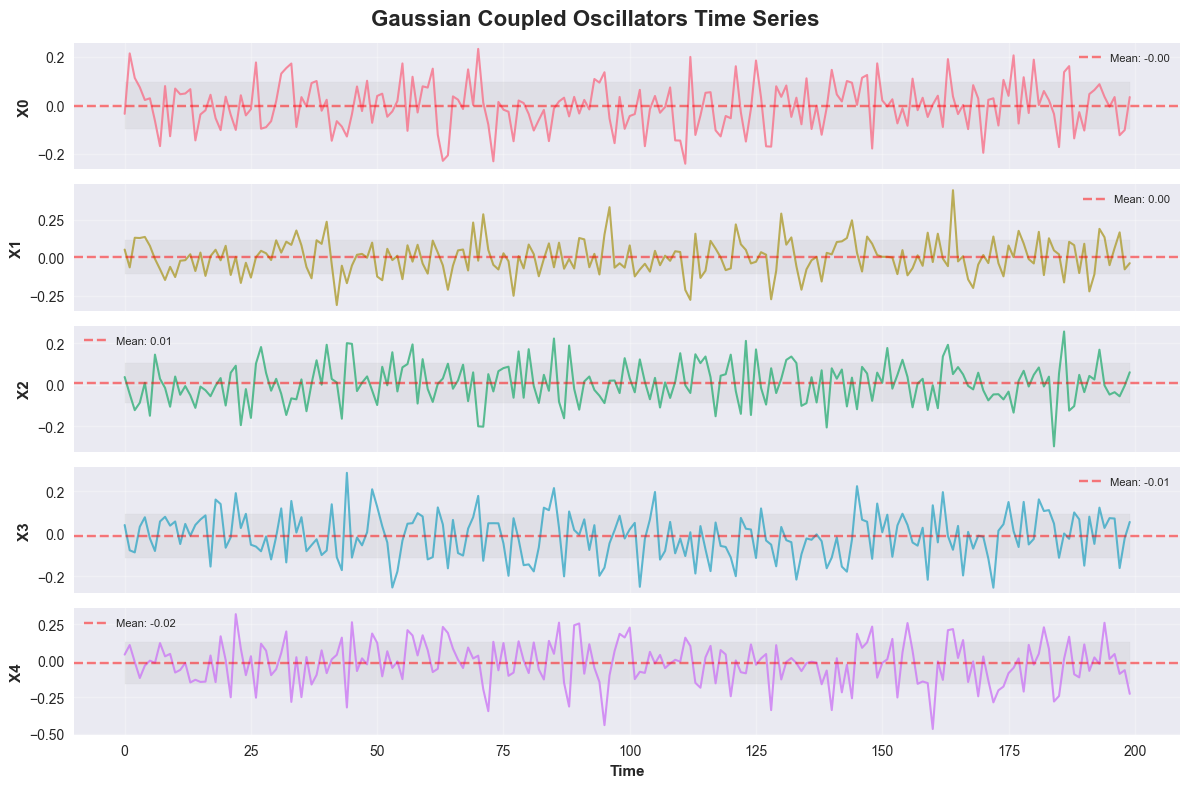

In [10]:
# Plot time series for all variables
fig, axes = plt.subplots(n_nodes, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Gaussian Coupled Oscillators Time Series', fontsize=16, fontweight='bold')

time = np.arange(T)
colors = sns.color_palette("husl", n_nodes)

for i in range(n_nodes):
    axes[i].plot(time, data[:, i], color=colors[i], alpha=0.8, linewidth=1.5)
    axes[i].set_ylabel(f'X{i}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    
    # Highlight the time series statistics
    mean_val = np.mean(data[:, i])
    std_val = np.std(data[:, i])
    axes[i].axhline(mean_val, color='red', linestyle='--', alpha=0.5, label=f'Mean: {mean_val:.2f}')
    axes[i].fill_between(time, mean_val-std_val, mean_val+std_val, alpha=0.1, color='gray')
    axes[i].legend(fontsize=8)

axes[-1].set_xlabel('Time', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Visualize Ground Truth Network

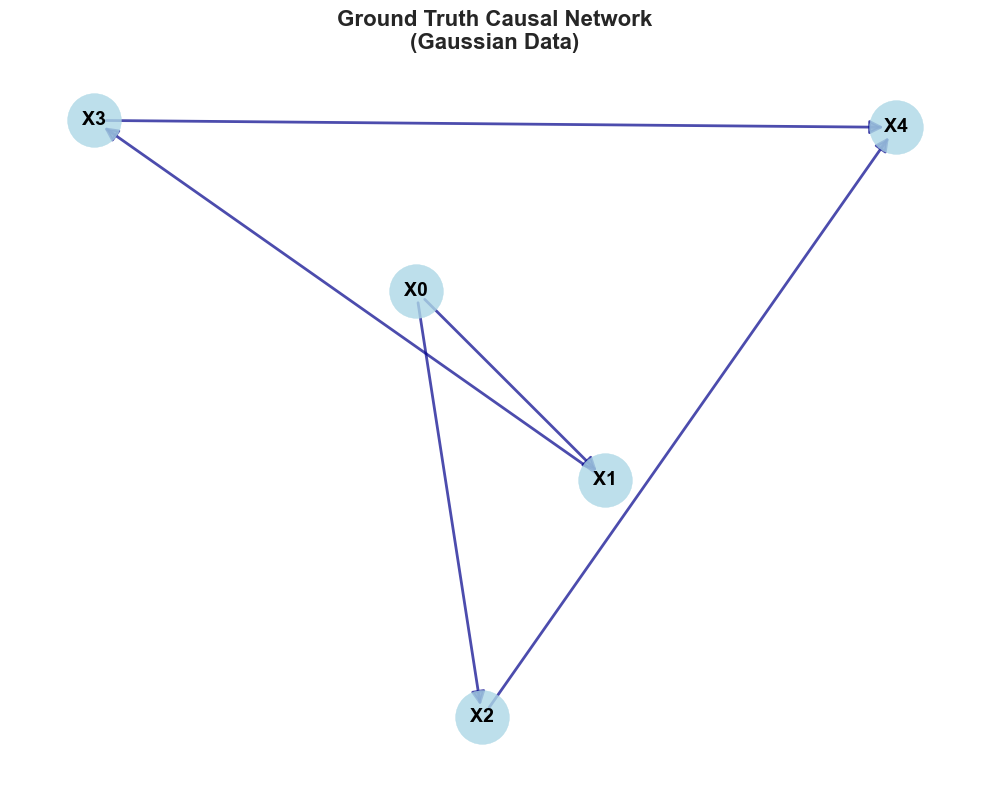

Ground Truth Network Statistics:
  Nodes: 5
  Edges: 5
  Edge density: 0.250
  Is DAG: True


In [11]:
# Plot ground truth network
plt.figure(figsize=(10, 8))

# Create layout
pos = nx.spring_layout(G_true, seed=seed, k=2, iterations=50)

# Draw network
nx.draw_networkx_nodes(G_true, pos, node_color='lightblue', 
                       node_size=1500, alpha=0.8)
nx.draw_networkx_edges(G_true, pos, edge_color='darkblue', 
                       arrows=True, arrowsize=20, width=2, alpha=0.7)
nx.draw_networkx_labels(G_true, pos, {i: f'X{i}' for i in range(n_nodes)},
                        font_size=14, font_weight='bold')

plt.title('Ground Truth Causal Network\n(Gaussian Data)', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print network statistics
print("Ground Truth Network Statistics:")
print(f"  Nodes: {G_true.number_of_nodes()}")
print(f"  Edges: {G_true.number_of_edges()}")
print(f"  Edge density: {nx.density(G_true):.3f}")
print(f"  Is DAG: {nx.is_directed_acyclic_graph(G_true)}")

## 5. Apply Causal Discovery

Use the k-Nearest Neighbor method to discover causal relationships.

In [12]:
# Apply causal discovery with Gaussian method
print("Applying causal discovery with Gaussian information method...")
print("This may take a few moments...\n")

# Discover network using different methods
methods_to_test = ['standard', 'alternative']
discovered_networks = {}

for method in methods_to_test:
    print(f"Running {method} method...")
    
    G_discovered = discover_network(
        data=data,
        method=method,
        information='knn',
        max_lag=2,
        alpha_forward=0.05,
        alpha_backward=0.05,
        n_shuffles=1000  # Reduced for faster execution
    )
    
    discovered_networks[method] = G_discovered
    print(f"  Discovered {G_discovered.number_of_edges()} edges")
    print(f"  Edges: {list(G_discovered.edges())}\n")

Applying causal discovery with Gaussian information method...
This may take a few moments...

Running standard method...
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
  Discovered 3 edges
  Edges: [('X0', 'X1'), ('X2', 'X4'), ('X3', 'X4')]

Running alternative method...
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
  Discovered 7 edges
  Edges: [('X0', 'X0'), ('X0', 'X1'), ('X2', 'X2'), ('X2', 'X4'), ('X3', 'X4'), ('X4', 'X0'), ('X4', 'X4')]



## 6. Calculate ROC-AUC Performance

In [ ]:
def calculate_roc_auc(true_adj, discovered_graph, node_names=None):
    """Calculate ROC-AUC for network discovery performance."""
    n = true_adj.shape[0]
    
    # Convert discovered graph to adjacency matrix
    if node_names is None:
        # Assume nodes are integers 0, 1, 2, ...
        G_int = nx.DiGraph()
        G_int.add_nodes_from(range(n))
        for edge in discovered_graph.edges():
            src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
            dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
            G_int.add_edge(src, dst)
        
        discovered_adj = nx.adjacency_matrix(G_int, nodelist=range(n)).toarray()
    else:
        discovered_adj = nx.adjacency_matrix(discovered_graph, nodelist=node_names).toarray()
    
    # Flatten adjacency matrices
    y_true = true_adj.flatten()
    y_scores = discovered_adj.flatten()
    
    # Remove self-loops (diagonal elements) for fair comparison
    mask = ~np.eye(n, dtype=bool).flatten()
    y_true = y_true[mask]
    y_scores = y_scores[mask]
    
    # Calculate ROC-AUC if there are both positive and negative examples
    if len(np.unique(y_true)) > 1:
        auc_score = roc_auc_score(y_true, y_scores)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        return auc_score, fpr, tpr
    else:
        return None, None, None

# Calculate ROC-AUC for each method
results = {}
plt.figure(figsize=(10, 6))

for method, G_disc in discovered_networks.items():
    auc_score, fpr, tpr = calculate_roc_auc(A_true, G_disc)
    
    if auc_score is not None:
        results[method] = {
            'auc': auc_score,
            'fpr': fpr,
            'tpr': tpr
        }
        
        # Plot ROC curve
        plt.plot(fpr, tpr, linewidth=2, label=f'{method} (AUC = {auc_score:.3f})')
        
        print(f"{method} method:")
        print(f"  ROC-AUC Score: {auc_score:.3f}")
    else:
        print(f"{method} method: Cannot calculate AUC (insufficient data)")

# Plot diagonal line for random performance
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves for Gaussian Causal Discovery', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*50)
print("PERFORMANCE SUMMARY - GAUSSIAN METHOD")
print("="*50)
print(f"Ground truth edges: {np.sum(A_true)}")
for method, G_disc in discovered_networks.items():
    print(f"{method.capitalize()} discovered edges: {G_disc.number_of_edges()}")
    if method in results:
        print(f"{method.capitalize()} ROC-AUC: {results[method]['auc']:.3f}")